In [2]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
import scipy
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## setup

In [3]:
#get GEFS members, 6h precip data

date = '20231001'
lead_time = 120 #hours
dat_dir = f'/scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/{date}/'
gefs_paths = sorted(glob(dat_dir+f'gefs*.t12z.f{lead_time:03d}'))
#print(gefs_paths)
filters = dict(productDefinitionTemplateNumber=11)
gefs_data = xr.open_mfdataset(gefs_paths, chunks=None,engine='grib2io', filters=filters, 
                              parallel=False, concat_dim=[pd.Index(np.arange(len(gefs_paths)), name="member")],combine="nested")



In [3]:
#objective function
def get_j(ck_arr, b_ik, mean, ens_mem, obs_error, S_grid,S_spec,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[2]], "y": ck_arr[np.shape(b_ik)[2]:]}
    x,y=grid_points
    j_r = residual_error(c_k, b_ik, mean,ens_mem,obs_error,x,y)
    j_a = barrier_func_gp(c_k, b_ik, S_grid)
    j_d = smoothness_func_spec(c_k, m_k, n_k, S_spec)
    #j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, m_k, n_k,S_spec)
    """
    Henderson, Hamill, and Nehrkorn:
    
    the weights for the smoothness and magnitude constraints were rescaled to take 
    into account the difference in the way these penalty functions are computed: 
    The smoothness constraint is computed in spectral space (with 60 degrees of freedom, 
    i.e. contributing terms to the penalty function), while the divergence 202 constraint is 
    summed over each grid point (100,794 in our case). Accordingly, 𝜆𝑝 was set to the
    ratio of the number of terms (1680) for the smoothness and magnitude constraints.
    
    """
    lambda_spec = np.shape(mean)[0]**2 / len(m_k)

    return np.log10(j_r + j_a + lambda_spec*j_d + lambda_spec*j_m)

def evaluate_at_new_grid(cx, cy, gx, gy, ens_mem):
    
    #interpolate ensemble member between displaced grid and gefs grid
    displaced_ens_at_gefs = scipy.interpolate.griddata((cx.ravel(), cy.ravel()), ens_mem.T.ravel(), (gx.ravel(), gy.ravel()), method="linear")
    aligned_ens = np.zeros_like(ens_mem)
    # griddata returns a list of points instead of the 2D field. just need to rearrange below
    # griddata also transposes the data array internally so will need to reverse that
    # see https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff
    leny, lenx = np.shape(cx)
    for i in range(lenx):
        for j in range(leny):
            point = leny*i+j
            aligned_ens[j, i] = displaced_ens_at_gefs[point]
    return aligned_ens

def residual_error(c_k,b_ik,ens_mean, ens_mem, obs_error, x,y):
    #grid point displacements from coeff * basis funcs
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    #new, distorted grid
    gy, gx=np.meshgrid(y,x ,indexing='ij')
    n_x_i = gx + c_xi
    n_y_i = gy + c_yi

    displaced_ens = evaluate_at_new_grid(n_x_i, n_y_i, gx, gy, ens_mem)
    
    before_sum = (ens_mean - displaced_ens)**2
    return np.sum(before_sum / obs_error**2)

def barrier_func_gp(c_k, b_ik,S_grid): #Ja
    #get displacements in grid space
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    return np.sum((c_xi / S_grid)**20) +  np.sum((c_yi / S_grid)**20)

def smoothness_func_spec(c_k, m_k, n_k, S_spec): #Jd
    nu_k = (m_k**2 + n_k**2)**(2)

    w_x = (1. / .005**2) * nu_k
    w_y = (1. / .005**2) * nu_k
    return np.sum(np.array([w_x, w_y]) *
                             np.array([c_k['x'], c_k['y']]) ** 2)

def divergence(field):
    "return the divergence of a n-D field"
    return np.sum(np.gradient(field),axis=0)

def divergence_func_gp(c_k, b_ik):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    nx, ny = len(c_xi), len(c_yi)

    dx = divergence(c_xi)
    dy = divergence(c_yi)
    return (dx+dy)**2

def magnitude_func_spec(c_k, m_k, n_k,S_spec):
    nu=1.
    d_o_f = len(m_k)
    n4nu_k = np.repeat(np.mean((m_k**2 + n_k**2)**(2*nu)), d_o_f)
    w_x = (1. / S_spec**2) * n4nu_k
    w_y = (1. / S_spec**2) * n4nu_k
    return np.sum(np.array([w_x, w_y]) *
                             np.array([c_k['x'], c_k['y']]) ** 2)
    

In [4]:
def basis_functions(target_x, target_y, m_k=None, n_k=None, xrange=(np.nan, np.nan), yrange=(np.nan, np.nan)):

    x = grid2fourier(target_x, xrange)
    y = grid2fourier(target_y, yrange)
    Y,X = np.meshgrid(y, x, indexing='ij')
    b_ik = np.zeros((len(y), len(x), len(m_k)))

    for mk in range(len(m_k)):
            b_ik[:,:, mk] = 2 * np.sin(m_k[mk] * X) * np.sin(n_k[mk] * Y)

    return b_ik

def grid2fourier(x, xrange):
    return (np.pi / np.diff(xrange)) * (x - xrange[0])

def basis_truncation(n=3):
    m_k = np.tile(np.arange(1, n+1),n)
    n_k = np.repeat(np.arange(1, n + 1), n)
    select = m_k**2 + n_k**2 <= n**2

    return m_k[select], n_k[select]

# Testing interpolators

## regular grid interpolator

In [13]:
import scipy.interpolate

ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()

min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361

mem=20
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon]

m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)

In [25]:
disp = [0.1, 1.]

#gefs grid
gx, gy=np.meshgrid(x,y ,indexing='ij')
gefs_grid_points = np.reshape((gx, gy), (2, -1), order='C').T

for value in disp:
    print(f'running with dx=dy={value}')
    start = datetime.datetime.now()
    #coalesced grid
    c_k = {"x": np.repeat(value, d_o_f), "y": np.repeat(value, d_o_f)}
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi
    
    #ensemble member at new grid points
    try:
        interp = scipy.interpolate.RegularGridInterpolator((n_x_i,n_y_i), ens_mem.T,bounds_error=False, fill_value=None)
    except:
        print('    regular grid only works if displacements are smaller than grid spacing')
        continue
    
    #get values at GEFS grid points, to compare with ensemble mean
    displaced_precip = interp(gefs_grid_points)
    
    finish = datetime.datetime.now()
    print(f'    succesfully finished in {(finish-start).total_seconds()} s')
    #print(finish - start)

running with dx=dy=0.1
    succesfully finished in 0.014208 s
running with dx=dy=1.0
    regular grid only works if displacements are smaller than grid spacing


Fast, but only works if displacements are smaller than grid spacing (because grid is not longer rectilinear). This also happens with [scipy.interpolate.RectBivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html#scipy.interpolate.RectBivariateSpline) and [scipy.interpolate.interpn](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html#scipy.interpolate.interpn) which wraps the RegularGridInterpolate function.

## griddata

In [24]:
disp = [0.1, 1.]

#gefs grid
gx, gy=np.meshgrid(x,y ,indexing='ij')
gefs_grid_points = np.reshape((gx, gy), (2, -1), order='C').T

for value in disp:
    for method in ['cubic', 'linear', 'nearest']:
        print(f'running with dx=dy={value} and method={method}')
        start = datetime.datetime.now()
        #coalesced grid
        c_k = {"x": np.repeat(value, d_o_f), "y": np.repeat(value, d_o_f)}
        c_xi = np.dot(b_ik, c_k['x'])
        c_yi = np.dot(b_ik, c_k['y'])
        n_x_i = x + c_xi
        n_y_i = y + c_yi
        xg, yg = np.broadcast_arrays(n_x_i[:, None], n_y_i[None, :])
    
        displaced_ens = scipy.interpolate.griddata((xg.ravel(), yg.ravel()), ens_mem.T.ravel(), (gx.ravel(), gy.ravel()), method=method)
    
        finish = datetime.datetime.now()
        print(f'    succesfully finished in {(finish-start).total_seconds()} s')

running with dx=dy=0.1 and method=cubic
    succesfully finished in 2.949332 s
running with dx=dy=0.1 and method=linear
    succesfully finished in 2.111316 s
running with dx=dy=0.1 and method=nearest
    succesfully finished in 0.134456 s
running with dx=dy=1.0 and method=cubic
    succesfully finished in 2.281267 s
running with dx=dy=1.0 and method=linear
    succesfully finished in 2.262369 s
running with dx=dy=1.0 and method=nearest
    succesfully finished in 0.138347 s


Slower to much slower depending on interpolation method, but can work with larger displacements. Cubic method uses [scipy.interpolate.CloughTocher2DInterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html#scipy.interpolate.CloughTocher2DInterpolator), linear method uses [scipy.interpolate.LinearNDInterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator), and nearest uses [scipy.interpolate.NearestNDInterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.NearestNDInterpolator.html#scipy.interpolate.NearestNDInterpolator). 

Most of the computation time is spend on the triangulation calculation...unfortunately for our case, this has to happen everytime the interpolation is evaluated since the input (coalesced) grid changes during the minimization run. If the interpolation was done the other way around (GEFS --> coalesced), this triangulation could be pre-computed and done just once per ensemble member (see [stackoverflow: speedup scipy griddata for multiple interpolations between two grids](https://stackoverflow.com/questions/51858194/storing-the-weights-used-by-scipy-griddata-for-re-use/51937990#51937990))

## KDTree

In [26]:
from scipy.spatial import KDTree

In [27]:
disp = [0.1, 1.]

#gefs grid
gx, gy=np.meshgrid(x,y ,indexing='ij')
gefs_grid_points = np.reshape((gx, gy), (2, -1), order='C').T

for value in disp:
    print(f'running with dx=dy={value}')
    start = datetime.datetime.now()
    #coalesced grid
    c_k = {"x": np.repeat(value, d_o_f), "y": np.repeat(value, d_o_f)}
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi
    distorted_grid_points = np.reshape((n_x_i, n_y_i), (2, -1), order='C').T
    distorted_tree = KDTree(distorted_grid_points)
    find_values_at_gefs = distorted_tree.query(gefs_grid_points)[1]

    finish = datetime.datetime.now()
    print(f'    succesfully finished in {(finish-start).total_seconds()} s')

running with dx=dy=0.1
    succesfully finished in 0.176837 s
running with dx=dy=1.0
    succesfully finished in 0.165041 s


About the same runtime as the griddata with nearest neighbor interpolation...because that's exactly what it is (just need to massage the output a bit since it returns the indices of the nearest neighbors as a 1D array)

# Testing objective function components

when does each penalty function dominate? scoping out penalty function weights, scalings, truncation, etc.

From Henderson, Hamill, and Nehrkorn:

"Sensitivity experiments with varying values for these parameters were evaluated through inspection of coalesced mean fields and selected ensemble member displacements in order to develop an initial “tuned” set of parameters: 𝑆 = 700𝑘𝑚, 𝑁𝑡𝑟𝑢𝑛𝑐 = 7, 𝜎 = 5𝑚𝑚 for precipitable water, 𝜎 = 1.3𝑚𝑚 for total precipitation, and 𝜆𝑝 = 1 for all terms 𝑝.

For the final configuration applied to the GEFSv12 forecasts, we modified these initial parameters as follows: the weights for the smoothness and magnitude constraints were rescaled to take into account the difference in the way these penalty functions are computed: The smoothness constraint is computed in spectral space (with 60 degrees of freedom, i.e. contributing terms to the penalty function), while the divergence constraint is summed over each grid point (100,794 in our case). Accordingly, 𝜆𝑝 was set to the ratio of the number of terms (1680) for the smoothness and magnitude constraintIn addition, we modified the length scale parameter – which represents the maximum expected displacements used in the FAT algorithm based on forecast length. We derived a scaling factor based on reported error growth of GFS hurricane track errors. The average of values reported in Dong et al. (2020) and Hazelton et al. (2018) is shown in Table 2, along with our derived scaling factor applied to the 96-hr value. Linear interpolation/extrapolation was used to arrive at the value of 𝑆 for each forecast length."

Should the ensemble variance at each point be used? Or a constant value? Maybe the mean...Afterall, these numbers are for the 96h forecast lead time.

#grid points / degrees of freedom for the penalty functions calculated in spectral space make sense. 

The scale (S) is time dependent in the paper; as we are interested in only the 6 hour forecast range, we should adopt the value S = 70 km based on their Table 2, which roughly corresponds to S = 0.7 degrees. Does it make sense to use the same scaling for both the spectral and the grid space? What is 0.7 degree displacement in spectral space?ngth."

In [35]:
#setup displacements
m_k, n_k = basis_truncation(9) #truncating the basis functions B_k to wavenumbers < 7
min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]]
    )
d_o_f = len(m_k)
#basis function coefficients, the target of our minimization
c_k = {"x": np.repeat(.015, d_o_f), "y": np.repeat(0., d_o_f)}

#physical displacements
c_xi = np.dot(b_ik, c_k['x'])
c_yi = np.dot(b_ik, c_k['y'])


In [33]:
14. * 1.32

18.48

Want $\sqrt{ \left(b_{ik} \cdot c_{kx})^2 + (b_{ik} \cdot c_{ky}\right)^2} < 0.7$. For simplicity, let's set $c_{ky} = 0$. LOL I am so bad at linear algebra...this can't be done, right? Geometry...

Text(0.5, 0, 'x grid points')

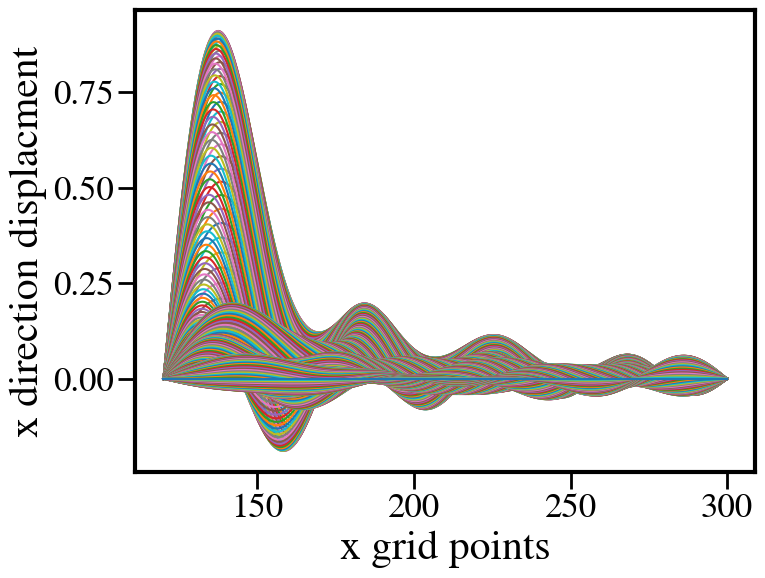

In [36]:
plt.plot(x, c_xi)
plt.ylabel('x direction displacment')
plt.xlabel('x grid points')

In [5]:
ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()

min_lon = 360
max_lon = 615
min_lat = 40
max_lat = 161

mem=3
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon]

In [38]:
ck3 = np.array([0.00760014, 0.00760014, 0.00760014, 0.00760014, 0.00760014,
       0.00760014, 0.00760014, 0.0373211 , 0.0373211 , 0.0373211 ,
       0.0373211 , 0.0373211 , 0.0373211 , 0.0373211 , 0.00928886,
       0.00928886, 0.00928886, 0.00928886, 0.00928886, 0.00928886,
       0.00928886, 0.01338303, 0.01338303, 0.01338303, 0.01338303,
       0.01338303, 0.01338303, 0.01338303, 0.00813122, 0.00813122,
       0.00813122, 0.00813122, 0.00813122, 0.00813122, 0.00813122,
       0.001846  , 0.001846  , 0.001846  , 0.001846  , 0.001846  ,
       0.001846  , 0.001846  , 0.00236417, 0.00236417, 0.00236417,
       0.00236417, 0.00236417, 0.00236417, 0.00236417, 0.04102581,
       0.04102581, 0.04102581, 0.04102581, 0.04102581, 0.04102581,
       0.04102581])

In [9]:
def get_j(ck_arr, b_ik, mean, ens_mem,obs_error, S_grid,S_spec,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[2]], "y": ck_arr[np.shape(b_ik)[2]:]}
    x,y=grid_points
    j_r = residual_error(c_k, b_ik, mean,ens_mem,obs_error,x,y)
    j_a = barrier_func_gp(c_k, b_ik, S_grid)
    j_d = smoothness_func_spec(c_k, m_k, n_k, S_spec)
    #j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, m_k, n_k,S_spec)

    lambda_spec = (np.shape(mean)[0]*np.shape(mean)[1]) / (len(m_k)*2)
    j_r_sqrt = np.sqrt(j_r)
    print(f'lambda square: {np.shape(mean)[0]**2}')
    print(f'lambda_spec: {lambda_spec}')
    print(f'Jr = {j_r:.2e}')
    print(f'Ja = {j_a:.2e}')
    print(f'Jd = {lambda_spec*j_d:.2e}')
    print(f'Jm = {lambda_spec*j_m:.2e}')
    #print(f'Jdiv = {j_div:.2e}')

    print(f'total = {j_r + j_a + lambda_spec*j_d + lambda_spec*j_m}')
    
    return j_r + j_a + lambda_spec*j_d + lambda_spec*j_m #+ j_div

#get displacement basis functions, transforms grid x,y to fourier space
m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])

std = 1.3 #np.mean(ens_std[ens_std>0])
S_a = 1.32 * 14.
S_mag = 1.

ck_arr = np.random.uniform(0.01, 0.05, len(m_k)*2)#np.repeat(.01, len(m_k)*2)

obj1 = get_j(ck_arr,b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon],ens_mem, 
                                            std, S_a,S_mag,(x,y), m_k, n_k)

lambda square: 14641
lambda_spec: 514.25
Jr = 2.85e+05
Ja = 2.61e-23
Jd = 9.59e+08
Jm = 2.43e+04
total = 959709541.5190102


In [32]:
len(m_k)

28

In [17]:
np.shape(b_ik)

(121, 255, 28)

In [18]:
len(ck3)

56

# Testing objective function gradient space

What does the objective func look like at different c_k values?

In [46]:
def get_j(ck_arr, b_ik, mean, ens_mem,obs_error, S_grid,S_spec,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[2]], "y": ck_arr[np.shape(b_ik)[2]:]}
    x,y=grid_points
    j_r = residual_error(c_k, b_ik, mean,ens_mem,obs_error,x,y)
    j_a = barrier_func_gp(c_k, b_ik, S_grid)
    j_d = smoothness_func_spec(c_k, m_k, n_k, S_spec)
    #j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, m_k, n_k,S_spec)

    lambda_spec = (np.shape(mean)[0] * np.shape(mean)[1]) / len(m_k)
    
    return np.log10(j_r + j_a + lambda_spec*j_d + lambda_spec*j_m)

In [49]:
mem=4
xrange,yrange,num=1,1,1000
m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)

std = np.mean(ens_std[ens_std>0])
S_a = 1.32 * 14.
S_mag = 1.

ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon]
ckx = np.linspace(1e-2, xrange,num)

def parallel_objective(ckx):
    c_k = {"x": np.repeat(ckx, d_o_f), "y": np.repeat(0.0, d_o_f)}
    ck_arr = np.ravel(np.array([c_k['x'], c_k['y']]))
    obj = get_j(ck_arr,b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon],ens_mem, 
                                            std, S_a,S_mag,(x,y), m_k, n_k)
    return obj
with multiprocessing.Pool(12) as p:
    jval = list(tqdm(p.imap(parallel_objective, ckx), total=len(ckx)))

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 0, 'x displacement coeffs')

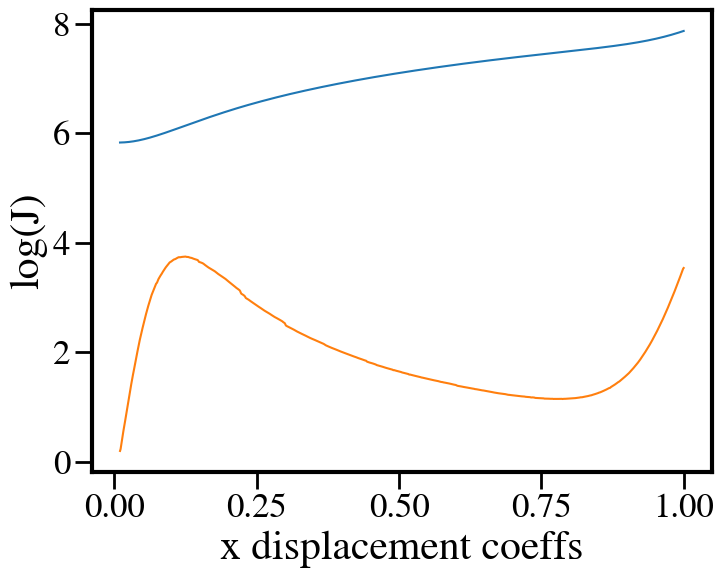

In [50]:

plt.plot(ckx, jval)
plt.plot(ckx, np.gradient(jval,ckx))
#plt.ylim([3, 9])
#plt.xlim([0.008, 0.1])
plt.ylabel('log(J)')
plt.xlabel('x displacement coeffs')

/tmp/ipykernel_55523/3986509409.py:3: RuntimeWarning: divide by zero encountered in log10
  cs=plt.contourf(X,Y,np.log10(jval))
/tmp/ipykernel_55523/3986509409.py:3: RuntimeWarning: invalid value encountered in log10
  cs=plt.contourf(X,Y,np.log10(jval))


(-5.0, 5.0)

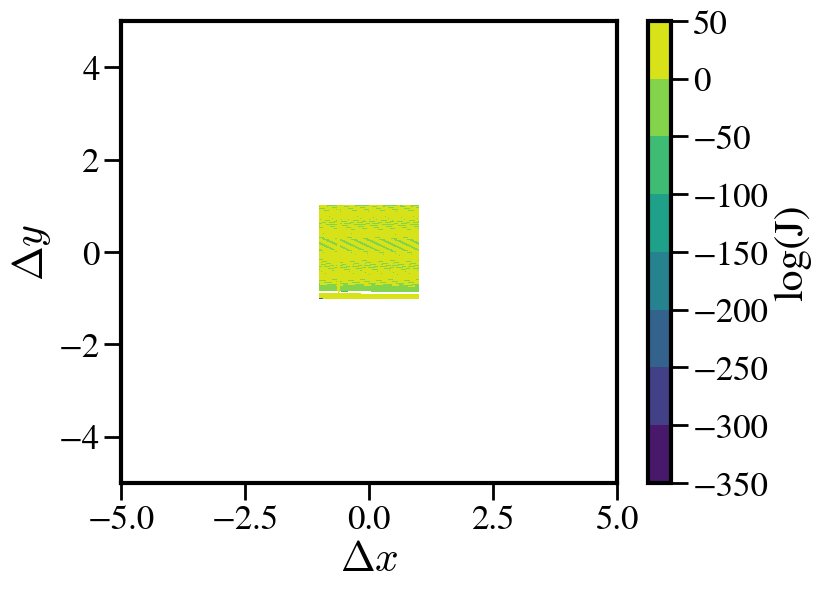

In [78]:
X,Y=np.meshgrid(np.linspace(xrange*-1,xrange,num),np.linspace(yrange*-1, yrange,num))

cs=plt.contourf(X,Y,np.log10(jval))
plt.colorbar(label='log(J)')
plt.xlabel('$\Delta x$')
plt.ylabel('$\Delta y$')

plt.xlim([-5,5])
plt.ylim([-5,5])

Text(0, 0.5, 'J$_a$')

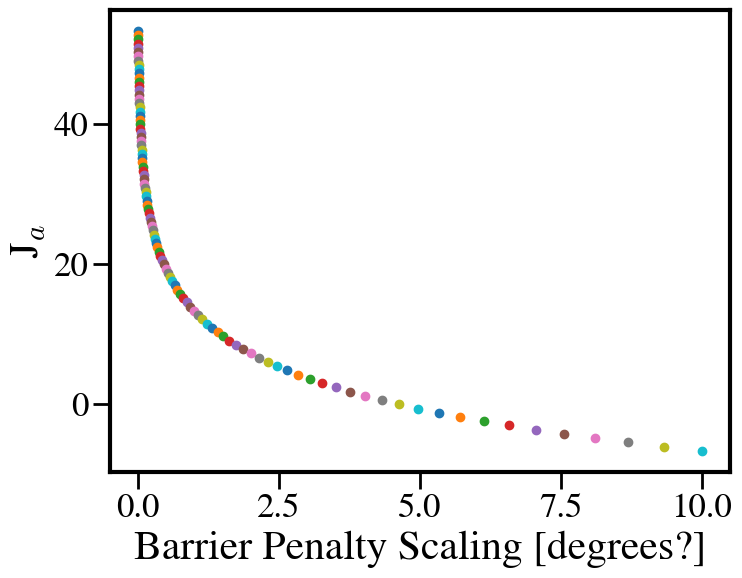

In [127]:
ckx = 0.1
scales = np.logspace(np.log10(ckx/10), np.log10(ckx*100), 100)
c_k = {"x": np.repeat(ckx, d_o_f), "y": np.repeat(0.0, d_o_f)}
for i in scales:
    plt.scatter(i, np.log10(barrier_func_gp(c_k, b_ik,i)))

plt.xlabel('Barrier Penalty Scaling [degrees?]')
plt.ylabel('J$_a$')

## Testing: Minimization constraints

In [61]:
import scipy

In [66]:
def get_j(ck_arr, b_ik, mean, ens_mem,obs_error, S_grid,S_spec,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[1]], "y": ck_arr[np.shape(b_ik)[1]:]}
    x,y=grid_points
    j_r = residual_error(c_k, b_ik, mean,ens_mem,obs_error,x,y)
    j_a = barrier_func_gp(c_k, b_ik, S_grid)
    j_d = smoothness_func_spec(c_k, m_k, n_k, S_spec)
    #j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, S_spec)

    lambda_spec = np.shape(mean)[0]**2 / len(m_k)
    
    return np.sqrt(j_r) + j_a + lambda_spec*j_d + lambda_spec*j_m# + j_div

In [72]:
ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()

min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361

mem=20
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon]

m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)

#free parameters
std = 1.3
S_a = 1.
S_mag = 0.8
bounds = [[-2.,2.]]*np.shape(b_ik)[1]*2 #constraints for the minimization routine

In [98]:
def constrain_nonzero(x):
    c = np.sum(np.abs(x)) - 1e-4
    return c

In [99]:
constraints = {'type': 'ineq', 'fun': constrain_nonzero}

In [100]:
mem=1
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon]
c_k = {"x": np.repeat(0.01, d_o_f), "y": np.repeat(0.01, d_o_f)}
ck_arr = np.ravel(np.array([c_k['x'], c_k['y']]))
minimize = scipy.optimize.minimize(fun=get_j,x0=ck_arr ,jac='3-point', 
                                       args=(b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon],ens_mem, 
                                            std, S_a,S_mag,(x,y), m_k, n_k), method='SLSQP',constraints=constraints,
                                      options={'disp':True, 'gtol': 5e-5,'finite_diff_rel_step': 10.})

/tmp/ipykernel_251015/200382056.py:5: OptimizeWarning: Unknown solver options: gtol
  minimize = scipy.optimize.minimize(fun=get_j,x0=ck_arr ,jac='3-point',


Optimization terminated successfully    (Exit mode 0)
            Current function value: 476.04169609762437
            Iterations: 10
            Function evaluations: 1203
            Gradient evaluations: 10


In [101]:
minimize.x

array([-0.00398681, -0.00398681, -0.00398681, -0.00398681, -0.00398681,
       -0.00398681, -0.00398681,  0.0042755 ,  0.0042755 ,  0.0042755 ,
        0.0042755 ,  0.0042755 ,  0.0042755 ,  0.0042755 ,  0.00044189,
        0.00044189,  0.00044189,  0.00044189,  0.00044188,  0.00044189,
        0.00044189, -0.00025312, -0.00026946, -0.00026906, -0.00026669,
       -0.00026661, -0.00026733, -0.00026761, -0.00818086, -0.00818086,
       -0.00818086, -0.00818086, -0.00818086, -0.00818086, -0.00818086,
        0.0043349 ,  0.0043349 ,  0.0043349 ,  0.0043349 ,  0.0043349 ,
        0.0043349 ,  0.0043349 , -0.00016006, -0.00016006, -0.00016006,
       -0.00016006, -0.00016006, -0.00016006, -0.00016006, -0.00019546,
       -0.00020004, -0.00019995, -0.00020209, -0.00020213, -0.00020211,
       -0.00020209])

In [105]:
#setup displacements
m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)

#free parameters
std = 1.3
S_a = 1.
S_mag = 0.8
bounds = [[-2.,2.]]*np.shape(b_ik)[1]*2 #constraints for the minimization routine

def minimize_routine(mem):
    min_lon = 240 
    max_lon = 601
    min_lat = 0
    max_lat = 361
    print(f'\nminimizing member {mem}')
    ck_minimized=[]
    ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon]
    #initialize coefficients
    c_k = {"x": np.repeat(0.01, d_o_f), "y": np.repeat(0.01, d_o_f)}
    ck_arr = np.ravel(np.array([c_k['x'], c_k['y']])) 
    #minimize
    #start = datetime.datetime.now()
    minimize = scipy.optimize.minimize(fun=get_j,x0=ck_arr ,jac='3-point', 
                                       args=(b_ik, raw_mean[min_lat:max_lat,min_lon:max_lon],ens_mem, 
                                            std, S_a,S_mag,(x,y), m_k, n_k), method='SLSQP',constraints=constraints,
                                      options={'disp':True, 'finite_diff_rel_step': 10.})
    print('    done minimizing')
    #coalesced grid
    c_k_minimized = {"x": minimize.x[:np.shape(b_ik)[1]], "y": minimize.x[np.shape(b_ik)[1]:]}
    ck_minimized.append(c_k_minimized['x'])
    c_xi = np.dot(b_ik, c_k_minimized['x'])
    c_yi = np.dot(b_ik, c_k_minimized['y'])
    n_x_i = x + c_xi
    n_y_i = y + c_yi

    print('    getting coalesced ensemble')
    aligned_ens = evaluate_at_new_grid(n_x_i, n_y_i, x, y, ens_mem)

    print('    done, returning')
    return aligned_ens, ck_minimized

In [106]:
start = datetime.datetime.now()
with multiprocessing.Pool(16) as p:
    result = p.map(minimize_routine, np.arange(4))
finish = datetime.datetime.now()
print(f'finished entire ensemble in {(finish-start).total_seconds()}s')


minimizing member 0
minimizing member 1
minimizing member 2
minimizing member 3



Optimization terminated successfully    (Exit mode 0)
            Current function value: 476.04169609762437
            Iterations: 10
            Function evaluations: 1203
            Gradient evaluations: 10
    done minimizing
    getting coalesced ensemble
Optimization terminated successfully    (Exit mode 0)
            Current function value: 465.58745182784577
            Iterations: 10
            Function evaluations: 1203
            Gradient evaluations: 10
    done minimizing
    getting coalesced ensemble
    done, returning
    done, returning
Optimization terminated successfully    (Exit mode 0)
            Current function value: 486.5919290083313
            Iterations: 17
            Function evaluations: 2026
            Gradient evaluations: 17
    done minimizing
    getting coalesced ensemble
    done, returning
Optimization terminated successfully    (Exit mode 0)
            Cu

In [107]:
result

[(array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ]], dtype=float32),
  [array([ 0.0411537 ,  0.04097926,  0.04101172,  0.04109906,  0.04117603,
           0.04095936,  0.04097687,  0.00136095,  0.00139696,  0.00140547,
           0.00135434,  0.00138394,  0.00142793,  0.00136703,  0.00014733,
           0.000145  ,  0.00014354,  0.00016601,  0.00013208,  0.00012582,
           0.00014354, -0.00041363, -0.00038262, -0.00048587, -0.00045402,
          -0.00047027, -0.00044473, -0.00041241])]),
 (array([[0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3],
         [0. , 0. , 0. , ..., 0.3, 0.3, 0.3],
         [0.1, 0.1, 0.1, ..., 0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0

## Testing: gradients

In [ ]:
#----------------------------#
# R code
#----------------------------#

g.calc.j.r <- function( c.k, r.i, b.ik, x.f, x.a, w.i, l.df, dx.f,
                       gridded.value=x.f$value,
                       dgridded.value=dx.f$value,
                       save=FALSE,
                       g.c.k ){
# $Id$
# Residual error loss functional
  n.x.dist <- n.adjusted.field(c.k, r.i, b.ik, x.f, l.df, dx.f,
                               gridded.value=gridded.value,
                               dgridded.value=dgridded.value,
                               save=save)
  g.x.dist <- 2 * w.i * (n.x.dist - x.a)
  g.c.k <- g.adjusted.field(c.k, r.i, b.ik, x.f,  l.df, dx.f,
                            gridded.value=gridded.value,
                            dgridded.value=dgridded.value,
                            use=save, 
                            g.x.dist, g.c.k)
  g.c.k }

n.adjusted.field <- function ( c.k, r.i, b.ik, x.f ,  l.df, dx.f,
                              gridded.value=x.f$value,
                              dgridded.value=dx.f$value,
                              save=FALSE, use=FALSE) {
# $Id$
# Calculate adjusted field
# c.i are the adjustment parameters at the r.i locations
  if (is.logical(use)) {
    c.i <- adjusted.parameters ( c.k, b.ik )
    n.a.i <- 1 + c.i$a
    n.x.i <- r.i$x + c.i$x
    n.y.i <- r.i$y + c.i$y 
    n.x.int <- n.bilin.xy.interp(x.f,list(x=n.x.i,y=n.y.i),f=gridded.value) 
    if (l.df) n.dx.int <- n.bilin.xy.interp(dx.f,list(x=n.x.i,y=n.y.i),f=dgridded.value)
    else n.dx.int <- 0 }
  if (!is.logical(save)) for (x in c('n.a.i','n.x.i','n.y.i','n.x.int',
                                     'n.dx.int')) assign(x,get(x),envir=save)
  n.a.i*(n.x.int + r.i$dt * n.dx.int) }

g.adjusted.field <- function ( c.k, r.i, b.ik, x.f , l.df, dx.f,
                              gridded.value=x.f$value,
                              dgridded.value=dx.f$value,
                              use=FALSE, 
                              g.x.dist, g.c.k) {
# $Id$
# Calculate Adjoint of adjusted field
# c.i are the adjustment parameters at the r.i locations
  if (!is.numeric(use)) {
    c.i <- adjusted.parameters ( c.k, b.ik )
    n.a.i <- 1 + c.i$a
    n.x.i <- r.i$x + c.i$x
    n.y.i <- r.i$y + c.i$y 
    n.x.int <- n.bilin.xy.interp(x.f,list(x=n.x.i,y=n.y.i),
                                 f=gridded.value) 
    if (l.df) n.dx.int <- n.bilin.xy.interp(dx.f,list(x=n.x.i,y=n.y.i),
                                            f=dgridded.value)
    else n.dx.int <- 0 }
  g.x.int <- n.a.i * g.x.dist
  g.dx.int <- n.a.i * r.i$dt * g.x.dist
  g.a.i <- (n.x.int + r.i$dt * n.dx.int) * g.x.dist
  g.c.i <- list(a=g.a.i,x=rep(0,length(g.a.i)),y=rep(0,length(g.a.i)))
  if (l.df) g.c.i <- 
    g.bilin.xy.interp(dx.f,list(x=n.x.i,y=n.y.i),g.dx.int,g.c.i,
                      f=dgridded.value)
  g.c.i <- g.bilin.xy.interp(x.f,list(x=n.x.i,y=n.y.i),g.x.int,g.c.i,
                             f=gridded.value)
  g.c.k <- g.adjusted.parameters( b.ik, g.c.i, g.c.k)
  g.c.k }

adjusted.parameters <- function ( c.k, b.ik ) {
# $Id$
# calculate adjusted parameters (by matrix multiply)
  list(a=b.ik%*%c.k$a,x=b.ik%*%c.k$x,y=b.ik%*%c.k$y) }

g.adjusted.parameters <- function ( b.ik, g.c.i, g.c.k ) {
# $Id$
# Adjoint of adjusted parameters (by matrix multiply)
  list(a=g.c.k$a + t(b.ik) %*% g.c.i$a,
       x=g.c.k$x + t(b.ik) %*% g.c.i$x,y=g.c.k$y + t(b.ik) %*% g.c.i$y)}

In [5]:
ens_mean = gefs_data.APCP.mean(dim='member')
raw_mean = ens_mean.data.compute()
ens_members = gefs_data.APCP.data.compute()
ens_std = gefs_data.APCP.std(dim='member').data.compute()

min_lon = 240 
max_lon = 601
min_lat = 0
max_lat = 361

mem=20
ens_mem = ens_members[mem,min_lat:max_lat,min_lon:max_lon]

In [7]:
m_k, n_k = basis_truncation(7)
y = gefs_data.latitude.data.compute().T[0][min_lat:max_lat]
x = gefs_data.longitude.data[0].compute()[min_lon:max_lon]
#get displacement basis functions, transforms grid x,y to fourier space
b_ik = basis_functions(x, y, m_k, n_k, [x[0], x[-1]], [y[0], y[-1]])
d_o_f = len(m_k)

c_k = {"x": np.repeat(0.01, d_o_f), "y": np.repeat(0.01, d_o_f)}
ck_arr = np.ravel(np.array([c_k['x'], c_k['y']]))

In [16]:
grad_res = -2 * (raw_mean[min_lat:max_lat,min_lon:max_lon] - ens_mem)

In [18]:
grad_res

array([[ 0.5809524 ,  0.5809524 ,  0.5809524 , ...,  0.5809524 ,
         0.5809524 ,  0.5809524 ],
       [ 0.16190477,  0.16190477,  0.16190477, ...,  0.03809524,
         0.03809524,  0.03809524],
       [ 0.14285713,  0.13333333,  0.13333333, ..., -0.02857143,
        -0.02857143, -0.02857143],
       ...,
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]], dtype=float32)

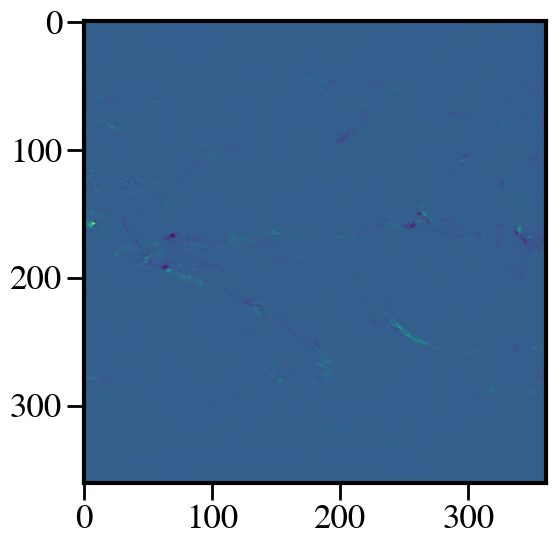

In [19]:
plt.imshow(grad_res)

In [25]:
np.shape(np.gradient(grad_res, axis=1))

(361, 361)

In [23]:
np.gradient(grad_res, axis=1)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00952381, -0.0047619 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [11]:
np.shape(np.dot(np.transpose(b_ik), grad_res))

(28, 361)

In [22]:
np.shape(np.transpose(b_ik))

(28, 361)

In [ ]:
#-------------------------#
#Python
#-------------------------#


def get_gradient_j(ck_arr, b_ik, mean_subsection, obs_error, S,S_mag,interp_object,grid_points, m_k, n_k):
    lambda_spec = np.shape(mean)[0]**2 / len(m_k)
    lambda_grid = 1.
    c_k = {"x": ck_arr[:np.shape(b_ik)[1]], "y": ck_arr[np.shape(b_ik)[1]:]}
    g_c_k = c_k
    #add residual 
    g_c_k = g_calc_j_r(c_k,b_ik,mean_subsection, obs_error, interp_object,grid_points,g_c_k)
    #add barrier
    g_c_k = g_calc_j_a(c_k, b_ik, lambda_grid, S, g_c_k)
    #add smoothness
    g_c_k = g_calc_j_d(c_k, m_k, n_k, lambda_spec, g_c_k)
    #add magnitude
    g_c_k = g_calc_j_m(lambda_spec, S_mag, g_c_k)
    #add divergence
    g_c_k = g_calc_j_div(c_k, b_ik,grid_points,lambda_grid,g_c_k)

    #get back to array
    g_c_k_array = np.ravel(np.array([g_c_k['x'], g_c_k['y']])) 

    return g_c_k_array

def g_bilinear(ix, iy, f, dx_n, dy_n, gxy):
    """
    Adjoint of bilinear interpolate in the unit box.
    """
    f00 = f[ix, iy]
    f10 = f[ix + 1, iy]
    f01 = f[ix, iy + 1]
    f11 = f[ix + 1, iy + 1]

    gxy['x'] *= (-f00 * (1 - dy_n) + f10 * (1 - dy_n) - f01 * dy_n + f11 * dy_n)
    gxy['y'] *= (-f00 * (1 - dx_n) - f10 * dx_n + f01 * (1 - dx_n) + f11 * dx_n)
    return gxy


def g_calc_j_r(c_k,b_ik,ens_mean, obs_error, interp_object,grid_points,g_c_k):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])

    n_x_i = grid_points[:,0] + c_xi
    n_y_i = grid_points[:,1] + c_yi
    xy_grid = np.meshgrid(n_x_i,n_y_i, indexing='ij')
    displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    displaced_precip = interp_object(displaced_grid)

    displaced_ens = np.ones_like(ens_mean)
    #print(np.shape(displaced_ens))
    for i in range(len(c_xi)):
        for j in range(len(c_yi)):
            point = len(c_yi)*i+j
            displaced_ens[j, i] = displaced_precip[point]
    
    g_x_dist = 2 * (1./obs_error) * (displaced_ens - ens_mean)
    x=grid_points[:,0]
    y=grid_points[:,1]
    dx,dy=0.5,0.5
    ix = x // dx + 1
    dx_n = (x % dx) / dx
    iy = y // dy + 1
    dy_n = (y % dy) / dy

    print(ix, iy)
    g_c_i = {}
    #gradient_of_displaced = np.gradient(displaced_ens)
    g_c_i['x'] = g_x_dist# * gradient_of_displaced[0]
    g_c_i['y'] = g_x_dist# * gradient_of_displaced[1]

    g_c_i = g_bilinear(ix, iy, displaced_ens, dx_n, dy_n, g_c_i)

    #g_c_k['x'] += np.sum((np.dot(np.transpose(b_ik), g_c_i['x'])),axis=1)
    #g_c_k['y'] += np.sum((np.dot(np.transpose(b_ik), g_c_i['y'])),axis=1)


    return g_c_i

def g_calc_j_d(c_k, m_k, n_k, lambda_d, g_c_k):

    nu_k = (m_k**2 + n_k**2)**(2)
    scale = 0.5
    weight = 1.
    w_k={'x': (weight / scale**2) * nu_k,
            'y': (weight / scale**2) * nu_k}
    
    g_c_k['x'] += lambda_d * 2 * w_k['x'] * c_k['x']
    g_c_k['y'] += lambda_d * 2 * w_k['y'] * c_k['y']
    return g_c_k

def g_calc_j_a(c_k, b_ik, lambda_a, S_a, g_c_k):
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    c_i = {"x": c_xi, "y": c_yi}
    g_c_i = c_i
    g_c_i['x'] += (lambda_a * 20) / (S_a) * (g_c_i['x'] / (S_a)) ** (19)
    g_c_i['y'] += (lambda_a * 20) / (S_a) * (g_c_i['y'] / (S_a)) ** (19)

    g_c_k['x'] += np.dot(np.transpose(b_ik), g_c_i['x'])
    g_c_k['y'] += np.dot(np.transpose(b_ik), g_c_i['y'])

    return g_c_k

def g_calc_j_m(lambda_m, S_mag, g_c_k):

    g_c_k['x'] += (lambda_m * 2) / (S_mag) * (g_c_k['x'] / (S_mag))
    g_c_k['y'] += (lambda_m * 2) / (S_mag) * (g_c_k['y'] / (S_mag))
    return g_c_k

def g_calc_j_div(c_k, b_ik,grid_points,lambda_div,g_c_k):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    
    n_x_i = grid_points[:,0] + c_xi
    n_y_i = grid_points[:,1] + c_yi
    xy_grid = np.meshgrid(c_xi,c_yi, indexing='ij')
    #displaced_grid = np.reshape(xy_grid, (2, -1), order='C').T
    #displaced_precip = interp_object(displaced_grid)
    nx, ny = len(n_x_i), len(n_y_i)
    
    # Update g.gp.c.i$x
    gp_c_i_x = xy_grid[0]
    gp_c_i_y = xy_grid[1]
    
    # Update middle elements
    gp_c_i_x[2:nx-1, 1:ny-2] += lambda_div * (
        gp_c_i_x[2:nx-1, 1:ny-2] - gp_c_i_x[0:nx-3, 1:ny-2] +
        gp_c_i_y[1:nx-2, 2:ny-1] - gp_c_i_y[1:nx-2, 0:ny-3]
    )
    # Update left edge elements
    gp_c_i_x[0:nx-3, 1:ny-2] -= lambda_div * (
        gp_c_i_x[2:nx-1, 1:ny-2] - gp_c_i_x[0:nx-3, 1:ny-2] +
        gp_c_i_y[1:nx-2, 2:ny-1] - gp_c_i_y[1:nx-2, 0:ny-3]
    )
    # Update top edge elements
    gp_c_i_y[1:nx-2, 2:ny-1] += lambda_div * (
        gp_c_i_x[2:nx-1, 1:ny-2] - gp_c_i_x[0:nx-3, 1:ny-2] +
        gp_c_i_y[1:nx-2, 2:ny-1] - gp_c_i_y[1:nx-2, 0:ny-3]
    )
    # Update bottom edge elements
    gp_c_i_y[1:nx-2, 0:ny-3] -= lambda_div * (
        gp_c_i_x[2:nx-1, 1:ny-2] - gp_c_i_x[0:nx-3, 1:ny-2] +
        gp_c_i_y[1:nx-2, 2:ny-1] - gp_c_i_y[1:nx-2, 0:ny-3]
    )
    g_gpc_i = {'x': gp_c_i_x, 'y': gp_c_i_y}
    for x in ['x', 'y']:
        g_gpc_i[x] = np.ravel(g_gpc_i[x])
    g_c_k['x'] += np.sum((np.dot(np.transpose(b_ik), g_c_i['x'])),axis=1)
    g_c_k['y'] += np.sum((np.dot(np.transpose(b_ik), g_c_i['y'])),axis=1)

    return g_c_k

$ J_r \sim \sum (\mathrm{mean} - \mathrm{ens}_i)^2$

$ \frac{d J_r}{dc_k} = ?$

## scratch

In [112]:
a = np.array([1,2,3,4])
b = np.array([5,6,7,8,9])
bb, aa = np.meshgrid(b, a,indexing='ij')

In [113]:
aa

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [114]:
bb

array([[5, 5, 5, 5],
       [6, 6, 6, 6],
       [7, 7, 7, 7],
       [8, 8, 8, 8],
       [9, 9, 9, 9]])

In [102]:
gefs_data.latitude.data.compute()

array([[ 90. ,  90. ,  90. , ...,  90. ,  90. ,  90. ],
       [ 89.5,  89.5,  89.5, ...,  89.5,  89.5,  89.5],
       [ 89. ,  89. ,  89. , ...,  89. ,  89. ,  89. ],
       ...,
       [-89. , -89. , -89. , ..., -89. , -89. , -89. ],
       [-89.5, -89.5, -89.5, ..., -89.5, -89.5, -89.5],
       [-90. , -90. , -90. , ..., -90. , -90. , -90. ]])

In [106]:
gefs_data.longitude.data.compute()

array([[  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5],
       [  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5],
       [  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5],
       ...,
       [  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5],
       [  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5],
       [  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5]])

In [118]:
by, ax = np.broadcast_arrays(b[:, None], a[None, :])

In [119]:
ax

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [120]:
by

array([[5, 5, 5, 5],
       [6, 6, 6, 6],
       [7, 7, 7, 7],
       [8, 8, 8, 8],
       [9, 9, 9, 9]])

In [26]:
g = grib2io.open('/scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/20231001/gefs01.t12z.f120')

In [27]:
g

mode = rb
name = /scratch2/STI/mdl-sti/Sidney.Lower/test_data/gefs/20231001/gefs01.t12z.f120
messages = 1
current_message = 0
size = 89459
closed = False
variables = ('APCP',)
levels = ('surface',)

In [28]:
g[0]

Section 0: discipline = 0 - Meteorological Products
Section 1: originatingCenter = 7 - US National Weather Service - NCEP (WMC)
Section 1: originatingSubCenter = 2 - NCEP Ensemble Products
Section 1: masterTableInfo = 2 - Version Implemented on 4 November 2003
Section 1: localTableInfo = 1 - Number of local table version used.
Section 1: significanceOfReferenceTime = 1 - Start of Forecast
Section 1: year = 2023
Section 1: month = 10
Section 1: day = 1
Section 1: hour = 12
Section 1: minute = 0
Section 1: second = 0
Section 1: refDate = 2023-10-01 12:00:00
Section 1: productionStatus = 0 - Operational Products
Section 1: typeOfData = 4 - Perturbed Forecast Products
Section 3: sourceOfGridDefinition = 0 - Specified in Code Table 3.1
Section 3: numberOfDataPoints = 259920
Section 3: interpretationOfListOfNumbers = 0 - There is no appended list
Section 3: gridDefinitionTemplateNumber = 0 - Latitude/Longitude
Section 3: shapeOfEarth = 6 - Earth assumed spherical with radius = 6,371,229.0 m


## Also include amplitude

In [ ]:
def basis_functions(target_x, target_y, m_k=None, n_k=None, xrange=(np.nan, np.nan), yrange=(np.nan, np.nan)):

    x = grid2fourier(target_x, xrange)
    y = grid2fourier(target_y, yrange)
    Y,X = np.meshgrid(y, x, indexing='ij')
    b_ik = np.zeros((len(y), len(x), len(m_k)))

    for mk in range(len(m_k)):
            b_ik[:,:, mk] = 2 * np.sin(m_k[mk] * X) * np.sin(n_k[mk] * Y)

    return b_ik

def grid2fourier(x, xrange):
    return (np.pi / np.diff(xrange)) * (x - xrange[0])

def basis_truncation(n=3):
    m_k = np.tile(np.arange(1, n+1),n)
    n_k = np.repeat(np.arange(1, n + 1), n)
    select = m_k**2 + n_k**2 <= n**2

    return m_k[select], n_k[select]

In [ ]:
#objective function
def get_j(ck_arr, b_ik, mean, ens_mem, obs_error, S_grid,S_spec,grid_points, m_k, n_k):
    c_k = {"x": ck_arr[:np.shape(b_ik)[2]], "y": ck_arr[np.shape(b_ik)[2]:]}
    x,y=grid_points
    j_r = residual_error(c_k, b_ik, mean,ens_mem,obs_error,x,y)
    j_a = barrier_func_gp(c_k, b_ik, S_grid)
    j_d = smoothness_func_spec(c_k, m_k, n_k, S_spec)
    #j_div = divergence_func_gp(c_k, b_ik)
    j_m = magnitude_func_spec(c_k, m_k, n_k,S_spec)
    lambda_spec = (np.shape(mean)[0]*np.shape(mean)[1]) / (len(m_k))

    return np.log10(j_r + j_a + lambda_spec*j_d + lambda_spec*j_m)

def evaluate_at_new_grid(cx, cy, gx, gy, ens_mem):
    
    #interpolate ensemble member between displaced grid and gefs grid
    displaced_ens_at_gefs = scipy.interpolate.griddata((cx.ravel(), cy.ravel()), ens_mem.T.ravel(), (gx.ravel(), gy.ravel()), method="linear")
    aligned_ens = np.zeros_like(ens_mem)
    # griddata returns a list of points instead of the 2D field. just need to rearrange below
    # griddata also transposes the data array internally so will need to reverse that
    # see https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff
    leny, lenx = np.shape(cx)
    for i in range(lenx):
        for j in range(leny):
            point = leny*i+j
            aligned_ens[j, i] = displaced_ens_at_gefs[point]
    return aligned_ens

def residual_error(c_k,b_ik,ens_mean, ens_mem, obs_error, x,y):
    #grid point displacements from coeff * basis funcs
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    #new, distorted grid
    gy, gx=np.meshgrid(y,x ,indexing='ij')
    n_x_i = gx + c_xi
    n_y_i = gy + c_yi

    displaced_ens = evaluate_at_new_grid(n_x_i, n_y_i, gx, gy, ens_mem)
    
    before_sum = (ens_mean - displaced_ens)**2
    return np.sum(before_sum / obs_error**2)

def barrier_func_gp(c_k, b_ik,S_grid): #Ja
    #get displacements in grid space
    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    return np.sum((c_xi / S_grid)**20) +  np.sum((c_yi / S_grid)**20)

def smoothness_func_spec(c_k, m_k, n_k, S_spec): #Jd
    nu_k = (m_k**2 + n_k**2)**(2)
    
    w_x = (1. / .1**2) * nu_k
    w_y = (1. / .1**2) * nu_k
    return np.sum(np.array([w_x, w_y]) *
                             np.array([c_k['x'], c_k['y']]) ** 2)

def divergence(field):
    "return the divergence of a n-D field"
    return np.sum(np.gradient(field),axis=0)

def divergence_func_gp(c_k, b_ik):

    c_xi = np.dot(b_ik, c_k['x'])
    c_yi = np.dot(b_ik, c_k['y'])
    nx, ny = len(c_xi), len(c_yi)

    dx = divergence(c_xi)
    dy = divergence(c_yi)
    return (dx+dy)**2

def magnitude_func_spec(c_k, m_k, n_k,S_spec):
    nu=1.
    d_o_f = len(m_k)
    n4nu_k = np.repeat(np.mean((m_k**2 + n_k**2)**(2*nu)), d_o_f)
    w_x = (1. / S_spec**2) * n4nu_k
    w_y = (1. / S_spec**2) * n4nu_k
    return np.sum(np.array([w_x, w_y]) *
                             np.array([c_k['x'], c_k['y']]) ** 2)
    